# ML classifier - XGBoost

In [24]:
import xgboost as xgb
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MultipleLocator
import shap
import graphviz
from matplotlib.pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler

In [32]:
# CHOOSE THE FILTER
ROI = "whole_tumour" # choose from: ['roi1', 'roi4', 'roi2', 'whole_tumour', 'brain']
condition = "no_Sex_no_Age" # choose from: "only_Sex_and_Age" or "no_Sex_no_Age" or "with_Sex_with_Age"
fontsize = 65
single_acquisitions = ["DTI_eddy_FA", "FLAIR", "DWI","T1_contrast", "DTI_eddy_MD"]

# Save full evaluation 
save_eval = False

def get_paths(acquisitions):
    environment = os.environ.get('PYRADIOMICS_ENV', 'local')  # Default to 'local' if the environment variable is not set
    
    if environment == 'local':
        base_directory = "/Users/Gabriel/MSc_Dissertation/pyRadiomics/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')

    return base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir

def process_target_columns(df):
    df = df.copy()
    grade_mapping = {2: 0, 3: 1, 4: 2}
    df["WHO CNS Grade"] = df["WHO CNS Grade"].map(grade_mapping)
    
    # Update 'IDH' values to be dichotomous 
    df.loc[df["IDH"] != "wildtype", "IDH"] = "mutant"

    # Encode IDH column in 1s and 0s
    df["IDH"] = pd.Categorical(df["IDH"], categories=["mutant", "wildtype"]).codes

    return df

def load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path):
    # Extract unique identifier from path
    def get_id(path):
        filename = os.path.basename(path)
        identifier = filename.replace(".csv", "")
        return identifier

    # Load data training 
    train_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in train_features_paths], axis=1)
    train_meta_data = pd.read_csv(train_data_path)
    train_meta_data["ID"] = train_meta_data["ID"].str.extract('(\d+)').astype(int)
    train_meta_data.set_index("ID", inplace=True)
    train_merged_data = train_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(train_features_data, left_index=True, right_index=True)
    train_target_columns = process_target_columns(train_merged_data[["WHO CNS Grade", "IDH"]])
    X_train = train_merged_data.drop(train_target_columns, axis=1)
    X_train["Sex"] = pd.Categorical(X_train["Sex"], categories=["M", "F"]).codes
    if condition == "only_Sex_and_Age":
        X_train = X_train[['Sex', 'Age at MRI']] # Drop all but age
    if condition == "no_Sex_no_Age":
        X_train = X_train.drop(['Sex', 'Age at MRI'], axis=1)  # Drop sex and age

    y_train = train_target_columns

    # Load data validation
    validation_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in validation_features_paths], axis=1)
    validation_meta_data = pd.read_csv(validation_data_path)
    validation_meta_data["ID"] = validation_meta_data["ID"].str.extract('(\d+)').astype(int)  # Add this line to convert 'ID' to int
    validation_meta_data.set_index("ID", inplace=True)
    validation_merged_data = validation_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(validation_features_data, left_index=True, right_index=True)
    validation_target_columns = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    X_validation = validation_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    X_validation["Sex"] = pd.Categorical(X_validation["Sex"], categories=["M", "F"]).codes 
    if condition == "only_Sex_and_Age":
        X_validation = X_validation[['Sex', 'Age at MRI']] # Drop all but age
    if condition == "no_Sex_no_Age":
        X_validation = X_validation.drop(['Sex', 'Age at MRI'], axis=1)  # Drop sex and age
    y_validation = validation_target_columns
    
    # Make sure that columns are in same order
    # Strip the "_training" and "_validation" parts from the column names
    X_train_columns_stripped = X_train.columns.str.replace("_training", "")
    X_validation_columns_stripped = X_validation.columns.str.replace("_validation", "")

    # Assert that the modified column names are the same
    assert (X_train_columns_stripped == X_validation_columns_stripped).all(), "The order of the columns in X_train and X_validation is not the same"

    X_train.columns = X_train.columns.str.replace('original_firstorder_', '').str.replace('_training_firstorder_original_', ' \n').str.replace('_whole_tumour', '\n').str.replace('_', ' ')

    
    return X_train, y_train, X_validation, y_validation

def train_model(X_train, y_train):
    params = {
        "objective": "multi:softmax",
        "learning_rate": 0.1,
        "max_depth": 2,
        "n_estimators": 100,
        "seed": 42,
        "num_class": 3,  # has to be the value of the case with the most categories (here: WHO grades (3))
    }

    xgb_clf = xgb.XGBClassifier(**params)
    clf = MultiOutputClassifier(xgb_clf)

    clf.fit(X_train, y_train)

    base_models = clf.estimators_  # the trained base models

    return clf, base_models


def make_predictions(clf, X_test):
    y_pred = clf.predict(X_test)
    return y_pred

def compute_shap_values(base_models, X):
    shap_values = [shap.TreeExplainer(model).shap_values(X) for model in base_models]
    return shap_values

def plot_shap_values(shap_values, X, save_directory, acquisition):
    # Set the global font size
    plt.rcParams.update({'font.size': fontsize})

    for i, values in enumerate(shap_values):
        print(f"SHAP values for output class {i}:")
        plt.figure(figsize=(20, 20))  # create a new figure
        fig, ax = plt.subplots()
        ax.set_xlim(0, 2.5)
        X.columns = X.columns.str.replace('original_firstorder_', '').str.replace('_training_firstorder_original_', ' ').str.replace('_whole_tumour', '')
        fig = shap.summary_plot(values, X, show=False, plot_size=[35,35])
        #plt.gca().xaxis.label.set_size(fontsize-13)
        plt.xlabel('')
        plt.text(1.1, -4.2, 'mean (|SHAP value|) \n average impact on model output magnitude', horizontalalignment='center', fontsize=fontsize)
        plt.gca().yaxis.label.set_size(fontsize)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize)
        if i == 1:
            # Get the current handles and labels
            handles, labels = plt.gca().get_legend_handles_labels()

            # Only use the first two handles and labels
            plt.legend(handles[:2], labels[:2], fontsize=fontsize, loc='lower right')
        else:
            plt.legend(fontsize=fontsize, loc='lower right')
        filename = f'shap_values_{acquisition}_class_{i}.png'
        filepath = os.path.join(save_directory, filename)
        plt.tight_layout()
        plt.savefig(filepath, dpi = 300)  # save the current figure to a file
        plt.close()  # clear the figure

def main():
    results = []

    # only use all inputs (1 combination only)
    acquisitions = tuple(single_acquisitions)
    
    # Get paths
    base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir = get_paths(acquisitions)

    # Load data
    X_train, y_train, X_validation, y_validation = load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path)

    # Train the model
    clf, base_models = train_model(X_train, y_train)

    # Compute SHAP values
    shap_values = compute_shap_values(base_models, X_train)
    
    # Call plot_shap_values in your main function
    #plot_shap_values(shap_values, X_train, base_directory, '_'.join(single_acquisitions))
    
    # Make predictions on the validation set
    y_pred = make_predictions(clf, X_validation)
        
    graph = xgb.to_graphviz(clf.estimators_[0], num_trees=90, fmap='', with_path=False)
    graph.render(filename='/Users/Gabriel/Desktop/tree_visualization', format='png', cleanup=True)
    

    return 

main()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


       WHO CNS Grade  IDH
ID                       
491.0              1    1
121.0              2    1
93.0               2    1
183.0              2    1
421.0              2    1
...              ...  ...
57.0               2    1
130.0              2    1
172.0              2    1
159.0              2    1
235.0              0    0

[395 rows x 2 columns]


## Combine as subplots

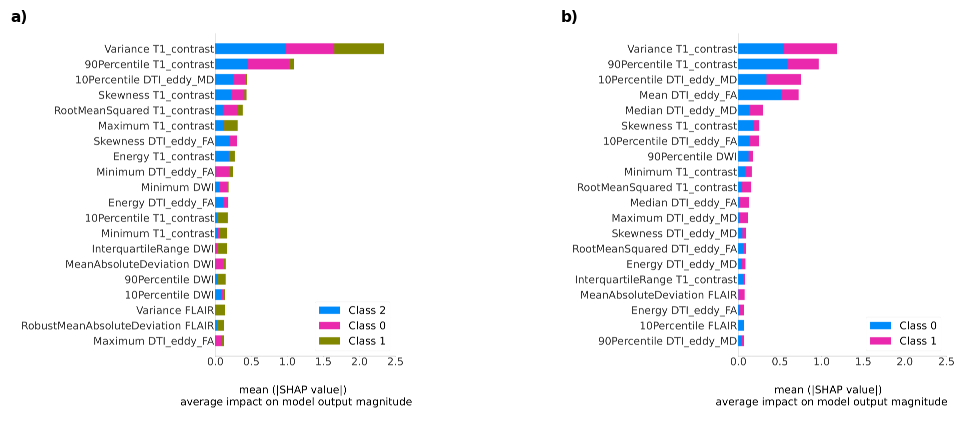

In [172]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Load both png figs
fig1 = mpimg.imread(f'/Users/Gabriel/Desktop/shap_values_DTI_eddy_FA_FLAIR_DWI_T1_contrast_DTI_eddy_MD_class_0.png')
fig2 = mpimg.imread(f'/Users/Gabriel/Desktop/shap_values_DTI_eddy_FA_FLAIR_DWI_T1_contrast_DTI_eddy_MD_class_1.png')

# Display the images in subplots
axs[0].imshow(fig1)
axs[0].axis('off')
axs[0].annotate("a)", xy=(0, 1), xycoords='axes fraction', fontsize=11, fontweight='bold')

axs[1].imshow(fig2)
axs[1].axis('off')
axs[1].annotate("b)", xy=(0, 1), xycoords='axes fraction', fontsize=11, fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig(f'/Users/Gabriel/Desktop/AUCROC_{ROI}.png', dpi=300)


# Show the figure
plt.show()

In [160]:
# CHOOSE THE FILTER
ROI = "whole_tumour" # choose from: ['roi1', 'roi4', 'roi2', 'whole_tumour', 'brain']
condition = "no_Sex_no_Age" # choose from: "only_Sex_and_Age" or "no_Sex_no_Age" or "with_Sex_with_Age"
fontsize = 20
single_acquisitions = ["DTI_eddy_FA", "FLAIR", "DWI","T1_contrast", "DTI_eddy_MD"]

def get_paths(acquisitions):
    environment = os.environ.get('PYRADIOMICS_ENV', 'local')  # Default to 'local' if the environment variable is not set
    
    if environment == 'local':
        base_directory = "/Users/Gabriel/MSc_Dissertation/pyRadiomics/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')
    elif environment == 'cluster':
        base_directory = "/cluster/project2/UCSF_PDGM_dataset/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')
    else:
        raise ValueError("Unknown environment: please set PYRADIOMICS_ENV to 'local' or 'cluster'")

    return base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir

def process_target_columns(df):
    df = df.copy()
    grade_mapping = {2: 0, 3: 1, 4: 2}
    df["WHO CNS Grade"] = df["WHO CNS Grade"].map(grade_mapping)
    
    # Update 'IDH' values to be dichotomous 
    df.loc[df["IDH"] != "wildtype", "IDH"] = "mutant"

    # Encode IDH column in 1s and 0s
    df["IDH"] = pd.Categorical(df["IDH"], categories=["mutant", "wildtype"]).codes

    return df

def load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path):
    # Extract unique identifier from path
    def get_id(path):
        filename = os.path.basename(path)
        identifier = filename.replace(".csv", "")
        return identifier

    # Load data training 
    train_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in train_features_paths], axis=1)
    train_meta_data = pd.read_csv(train_data_path)
    train_meta_data["ID"] = train_meta_data["ID"].str.extract('(\d+)').astype(int)
    train_meta_data.set_index("ID", inplace=True)
    train_merged_data = train_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(train_features_data, left_index=True, right_index=True)
    train_target_columns = process_target_columns(train_merged_data[["WHO CNS Grade", "IDH"]])
    X_train = train_merged_data.drop(train_target_columns, axis=1)
    X_train["Sex"] = pd.Categorical(X_train["Sex"], categories=["M", "F"]).codes
    if condition == "only_Sex_and_Age":
        X_train = X_train[['Sex', 'Age at MRI']] # Drop all but age
    if condition == "no_Sex_no_Age":
        X_train = X_train.drop(['Sex', 'Age at MRI'], axis=1)  # Drop sex and age

    y_train = train_target_columns

    # Load data validation
    validation_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in validation_features_paths], axis=1)
    validation_meta_data = pd.read_csv(validation_data_path)
    validation_meta_data["ID"] = validation_meta_data["ID"].str.extract('(\d+)').astype(int)  # Add this line to convert 'ID' to int
    validation_meta_data.set_index("ID", inplace=True)
    validation_merged_data = validation_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(validation_features_data, left_index=True, right_index=True)
    validation_target_columns = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    X_validation = validation_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    X_validation["Sex"] = pd.Categorical(X_validation["Sex"], categories=["M", "F"]).codes 
    if condition == "only_Sex_and_Age":
        X_validation = X_validation[['Sex', 'Age at MRI']] # Drop all but age
    if condition == "no_Sex_no_Age":
        X_validation = X_validation.drop(['Sex', 'Age at MRI'], axis=1)  # Drop sex and age
    y_validation = validation_target_columns
    
    # Make sure that columns are in same order
    # Strip the "_training" and "_validation" parts from the column names
    X_train_columns_stripped = X_train.columns.str.replace("_training", "")
    X_validation_columns_stripped = X_validation.columns.str.replace("_validation", "")

    # Assert that the modified column names are the same
    assert (X_train_columns_stripped == X_validation_columns_stripped).all(), "The order of the columns in X_train and X_validation is not the same"

    
    return X_train, y_train, X_validation, y_validation

def train_model(X_train, y_train):
    params = {
        "objective": "multi:softmax",
        "learning_rate": 0.1,
        "max_depth": 5,
        "n_estimators": 100,
        "seed": 42,
        "num_class": 3,  # has to be the value of the case with the most categories (here: WHO grades (3))
    }

    xgb_clf = xgb.XGBClassifier(**params)
    clf = MultiOutputClassifier(xgb_clf)

    clf.fit(X_train, y_train)

    base_models = clf.estimators_  # the trained base models

    return clf, base_models


def make_predictions(clf, X_test):
    y_pred = clf.predict(X_test)
    return y_pred

def compute_shap_values(base_models, X):
    shap_values = [shap.TreeExplainer(model).shap_values(X) for model in base_models]
    return shap_values

def plot_shap_values(shap_values, base_models, X, save_directory, acquisition, y_train):
    # Set the global font size
    plt.rcParams.update({'font.size': fontsize})

    target_columns = ["WHO CNS Grade", "IDH"]

    # Create figure with 5 subplots
    fig, axs = plt.subplots(nrows=5, figsize=(20, 25))  # Change size as needed
    
    # Counter to keep track of which subplot we are on
    subplot_counter = 0

    # Subplot labels
    subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)']
    
    # Iterate over each target column (WHO CNS Grade and IDH)
    for i, target in enumerate(target_columns):
        # Check the number of classes in the target column
        num_classes = len(np.unique(y_train[target]))
        print(target)
        # Iterate over each class within the target column
        for class_idx in range(num_classes):
            print(class_idx)
            values = shap_values[i][class_idx]
            X.columns = X.columns.str.replace('original_firstorder_', '').str.replace('_training_firstorder_original_', ' ').str.replace('_whole_tumour', '')
            # We need to make shap.summary_plot plot into a specific axes object, but it does not currently support that option
            # So we temporarily change the current axes to the one we want the plot to go into
            plt.sca(axs[subplot_counter])
            mpl.rcParams['font.size'] = fontsize
            shap.summary_plot(values, X, show=False, plot_size=None, max_display=5, color_bar = False)  # remove plot_size
            cbar = plt.colorbar()
            cbar.ax.tick_params(labelsize=20)
            cbar.ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
            
            plt.gca().xaxis.label.set_size(20)
            plt.gca().yaxis.label.set_size(20)
            plt.gca().xaxis.set_tick_params(labelsize=20)
            plt.gca().yaxis.set_tick_params(labelsize=20)
            axs[subplot_counter].text(-0.3, 1.1, subplot_labels[subplot_counter], transform=axs[subplot_counter].transAxes, fontsize=fontsize+2, fontweight='bold', va='top', ha='right')
            subplot_counter += 1

    # Save the full figure
    filename = f'shap_values_{acquisition}_combined.png'
    filepath = os.path.join(save_directory, filename)
    plt.tight_layout()
    plt.savefig(filepath, dpi = 300)
    plt.close()


def main():
    results = []

    # only use all inputs (1 combination only)
    acquisitions = tuple(single_acquisitions)
    
    # Get paths
    base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir = get_paths(acquisitions)

    # Load data
    X_train, y_train, X_validation, y_validation = load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path)

    # Train the model
    clf, base_models = train_model(X_train, y_train)

    # Compute SHAP values
    shap_values = compute_shap_values(base_models, X_train)
    
    # Call plot_shap_values in your main function
    plot_shap_values(shap_values, base_models, X_train, base_directory, '_'.join(single_acquisitions), y_train)
    
    # Make predictions on the validation set
    y_pred = make_predictions(clf, X_validation)

    # Assess model performance
    target_columns = ["WHO CNS Grade", "IDH"]
    result = {
        "Acquisition": acquisitions,
    }

    for i, col in enumerate(target_columns):
        report = classification_report(y_validation[col], y_pred[:, i], output_dict=True)

        # Update the values to your results dictionary.
        result.update({
            col + " balanced-accuracy": balanced_accuracy_score(y_validation[col], y_pred[:, i]),
            f"{col} f1-score": f1_score(y_validation[col], y_pred[:, i], average='micro')
        })

    results.append(result)

    # Save detailed evaluation in text file
    if save_eval:
        save_evaluation(acquisitions, target_columns, y_validation, y_pred, base_directory)


    results_df = pd.DataFrame(results)


    return results_df, eval_dir

results_df, eval_dir = main()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


WHO CNS Grade
0
1
2
IDH
0
1
